In [ ]:
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle
import re
import numpy as np
import pandas as pd

with open('withTrivia.pkl', 'rb') as f:
    df = pickle.load(f)

In [11]:
res=[]
for rejector in df['Base_Phi_TriviaQA_GLUE'][10000]:
    res.append([rejector, df['Base_Phi_TriviaQA_GLUE'][10000][rejector]['roc_auc']])

In [13]:
res

[['Dropout Agreement MV generic', 0.5288800927265029],
 ['Dropout Agreement DP generic', 0.5497333227193122],
 ['Distilbert Embedding SVM', 0.5915946694836745],
 ['Distilbert Embedding Random Forest', 0.5704634438757331],
 ['Distilbert Embedding Logistic Regression', 0.5918870597901497],
 ['Distilbert Embedding Simple NN', 0.5866481381339839],
 ['TinyBert Embedding SVM', 0.5917130927977665],
 ['TinyBert Embedding Random Forest', 0.5432601414372608],
 ['TinyBert Embedding Logistic Regression', 0.5961282912249373],
 ['TinyBert Embedding Simple NN', 0.5894515218967852],
 ['Bert Embedding SVM', 0.5480180338795478],
 ['Bert Embedding Random Forest', 0.5655839841375638],
 ['Bert Embedding Logistic Regression', 0.5531039484219307],
 ['Bert Embedding Simple NN', 0.5623839346722503],
 ['RoBERTa Embedding SVM', 0.6045918902037719],
 ['RoBERTa Embedding Random Forest', 0.5658391706595236],
 ['RoBERTa Embedding Logistic Regression', 0.604104573026313],
 ['RoBERTa Embedding Simple NN', 0.5959134524

In [24]:
(0.5704634438757331+0.5432601414372608+0.5655839841375638+0.5658391706595236+0.5655509723287683)/5

0.5621395424877699

In [18]:
groups = {
    'RF': ['Tf-Idf Embedding Random Forest', 'TinyBert Embedding Random Forest', 
           'Bert Embedding Random Forest', 'Distilbert Embedding Random Forest', 
           'RoBERTa Embedding Random Forest'],
    'SVM': ['Tf-Idf Embedding SVM', 'TinyBert Embedding SVM', 
            'Bert Embedding SVM', 'Distilbert Embedding SVM', 
            'RoBERTa Embedding SVM'],
    'MLP': ['Tf-Idf Embedding Simple NN', 'TinyBert Embedding Simple NN', 
           'Bert Embedding Simple NN', 'Distilbert Embedding Simple NN', 
           'RoBERTa Embedding Simple NN'],
    'LR': ['Tf-Idf Embedding Logistic Regression', 'TinyBert Embedding Logistic Regression', 
           'Bert Embedding Logistic Regression', 'Distilbert Embedding Logistic Regression', 
           'RoBERTa Embedding Logistic Regression'],
    'IF': ['Tf-Idf Outlier generic', 'TinyBert Outlier generic', 
                'Bert Outlier generic', 'Distilbert Outlier generic', 
                'RoBERTa Outlier generic'],
    'Bert': ['Bert Rejector generic'],
    'TBert': ['TinyBert Rejector generic'],
    'RBert': ['RoBERTa Rejector generic'],
    'DBert': ['Distilbert Rejector generic']
}

In [26]:
data_dict = dict(res)
group_averages = {}

for group, names in groups.items():
    values = [data_dict[name] for name in names if name in data_dict]
    avg = np.mean(values) if values else float('nan')
    group_averages[group] = avg

# Display results
for group, avg in group_averages.items():
    print(f"{group}: {avg:.3f}")

RF: 0.562
SVM: 0.586
MLP: 0.581
LR: 0.590
IF: 0.514
Bert: 0.654
TBert: 0.647
RBert: 0.699
DBert: 0.705


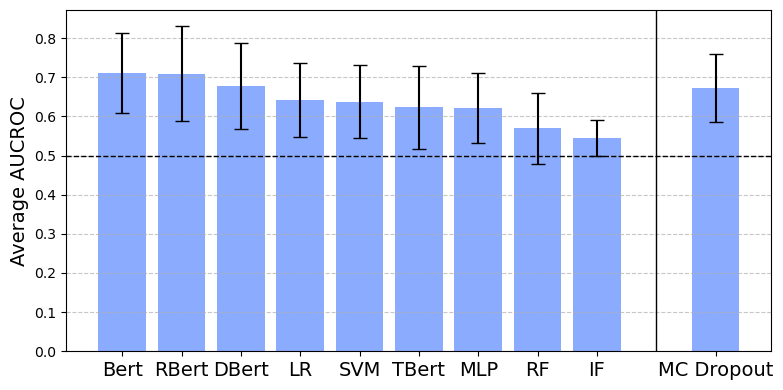

In [6]:
temp = df[df['Dataset'].str.contains('Base_Phi', na=False)]
temp = temp[~temp['Dataset'].str.contains('Interpolated', na=False)]

max_data_size = temp.groupby('Dataset')['Data_size'].max().reset_index()

check = []
temp_array = []
for _, row in max_data_size.iterrows():
    dataset = row['Dataset']
    size = row['Data_size']
    for group in groups.keys():
        models = groups[group]
        for model in models:
            roc = df_roc[dataset][size][model]['roc_auc']
            check.append([dataset, size, model, roc])
            temp_array.append([group, roc])

temp_df = pd.DataFrame(temp_array, columns=['method', 'roc'])

stats_df = temp_df.groupby("method")["roc"].agg(mean="mean", std="std").reset_index()
stats_df_sorted = stats_df.sort_values(by="mean", ascending=False)

#DROPOUT
temp_array = []
for _, row in max_data_size.iterrows():
    dataset = row['Dataset']
    size = row['Data_size']
    try:
        roc = df_roc[dataset][size]['Dropout Agreement DP generic']['roc_auc']
        temp_array.append(['Dropout', roc, dataset])
    except:
        print(dataset)

t_df = pd.DataFrame(temp_array, columns=['method', 'roc', 'dataset'])
s_df = t_df.groupby("method")["roc"].agg(mean="mean", std="std").reset_index()

new_bar = pd.DataFrame({"method": ["MC Dropout"], "mean": [s_df['mean'][0]], "std": [s_df['std'][0]]})
stats_df_sorted = pd.concat([stats_df_sorted, new_bar], ignore_index=True)

x = np.arange(len(stats_df_sorted))  
width = 0.8

x = list(range(len(stats_df_sorted) - 1)) + [len(stats_df_sorted) - 1 + 1]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    x, stats_df_sorted["mean"], 
    yerr=stats_df_sorted["std"], 
    capsize=5, alpha=0.75, width=width, color="#648FFF", label="Average ROC"
)

middle_of_gap = (x[-2] + x[-1]) / 2
ax.axvline(x=middle_of_gap, color='black', linestyle='-', linewidth=1)

ax.axhline(
    y=0.5,                 
    color='black',      
    linestyle='--',       
    linewidth=1 
)

ax.set_ylabel('Average AUCROC', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(stats_df_sorted["method"], rotation=0, ha='center', fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('exp1_classifier', dpi=300, bbox_inches='tight') 
plt.show()

In [97]:
stats_df_sorted['mean'] = stats_df_sorted['mean'].round(3)
stats_df_sorted['std'] = stats_df_sorted['std'].round(3)

In [98]:
stats_df_sorted

,method,mean,std
0,Bert,0.710,0.102
1,RBert,0.709,0.121
2,DBert,0.678,0.109
3,LR,0.642,0.093
4,SVM,0.637,0.094
5,TBert,0.623,0.107
6,MLP,0.622,0.090
7,RF,0.570,0.091
8,IF,0.545,0.045
9,MC Dropout,0.673,0.086


In [144]:
temp_df = pd.DataFrame(check, columns=['dataset', 'size', 'method', 'roc'])
temp_df['roc'] = temp_df['roc'].round(4)

In [146]:
temp_df[temp_df['roc'] <= 0.5].sort_values(by="roc", ascending=True)

,dataset,size,method,roc
494,Base_Phi_TransformationSpellcheck,10000,TinyBert Embedding Random Forest,0.3328
493,Base_Phi_TransformationSpellcheck,10000,Tf-Idf Embedding Random Forest,0.3630
319,Base_Phi_QA_4Shot,10000,Tf-Idf Embedding Random Forest,0.3960
321,Base_Phi_QA_4Shot,10000,Bert Embedding Random Forest,0.4129
317,Base_Phi_GLUE_WNLI,635,RoBERTa Rejector generic,0.4256
320,Base_Phi_QA_4Shot,10000,TinyBert Embedding Random Forest,0.4309
497,Base_Phi_TransformationSpellcheck,10000,RoBERTa Embedding Random Forest,0.4359
229,Base_Phi_GLUE_RTE,2490,TinyBert Rejector generic,0.4378
323,Base_Phi_QA_4Shot,10000,RoBERTa Embedding Random Forest,0.4390
322,Base_Phi_QA_4Shot,10000,Distilbert Embedding Random Forest,0.4400


In [132]:
17 * RF
2 * SVM
2 * MLP
1 * IF
1 * TinyBert
1 * Roberta

NameError: name 'RF' is not defined